# **Aprendizaje Automático para Machine Learning**

## Actividad individual 3: "Frameworks"

Fabio Santamaría Iglesias

21/07/2021

# **Introducción**

El objetivo de esta actividad consiste en entrenar un modelo de aprendizaje automático capaz de identificar el contenido de las imágenes del conjunto de datos CIFAR10. Este consta de 50.000 imágenes de entrenamiento y 10.000 de prueba clasificadas en 10 clases: 

* 'plane' (avión) 
* 'car' (coche) 
* 'bird' (pájaro) 
* 'cat' (gato) 
* 'deer' (ciervo) 
* 'dog' (perro) 
* 'frog' (rana) 
* 'horse' (caballo) 
* 'ship' (barco) 
* 'truck' (camión)

Cada imagen tiene una dimensión de 32 x 32 pixels y está a color (3 canales).

Entrenaremos dos modelos, uno por medio del framework de *tensorflow* y otro mediante el framework de *pytorch*. Ambos se basarán en la misma arquitectura, una red multicapa densa constituida por cuatro capas lineales de la siguiente forma: 

* Capa de entrada: $32 \cdot 32 \cdot 3$ neuronas de entrada.
* Primera capa oculta: $128$ neuronas, función de activación *Relu*.
* Segunda capa oculta: $64$ neuronas, función de activación *Relu*.
* Capa de salida: $10$ nueronas, en correspondencia al número de clases a identificar. Función de activación *Softmax*.

Usaremos como optimizador el método Stochastic Gradient Descent (SGD) aplicado sobre la función de coste definida como *cross entropy*. Además, emplearemos un tamaño de lote (batch size) de 16 imágenes, entrenado durante al menos 100 iteraciones (epochs).

Por último, se evaluará el modelo mediante las curvas loss para los datos de entrenamiento y validación en función de la iteración. Dado que los conjuntos de datos están equilibrados, y por tanto disponemos de la misma cantidad de instancias para cada clase, calcularemos la *accuracy*. También usaremos los indicadores *precision*, *recall* y *f1-score* así como la matriz de confusión para desagregar el comportamiento de la red por clase.

Comenzamos importando las librerías comunes que usaremos para visualizar los resultados en ambos frameworks:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# **Tensorflow**

Comenzamos con el framework de *tensorflow*. El primer paso consiste en importar las librerías necesarias:

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers

## Dataset

Además de los componentes para construir nuestro modelo de aprendizaje, el *dataset* de CIFAR-10 también puede ser cargado directamente de las librerías de *tensorflow*:

In [ ]:
from tensorflow.keras import datasets
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()


170500096/170498071 [==============================] - 2s 0us/step


Podemos tratar de visualizar algunos ejemplos del *dataset*:

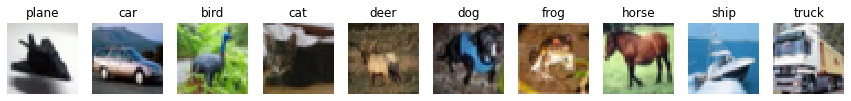

In [ ]:
# reshape grayscale images to have a single channel
width, height, channels = x_train.shape[1], x_train.shape[2], 3
trainX = x_train.reshape((x_train.shape[0], width, height, channels))

u, indices = np.unique(y_train, return_index=True)
X_u = trainX[indices]
y_u = y_train[indices]

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u, y_u):
    ax.set_axis_off()
    image = image.reshape(32, 32, 3)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(classes[int(label)])


A continuación, adaptamos el *dataset* de entrenamiento a nuestro modelo. 

Por un lado, para estandarizar los datos de entrada de nuestra red, normalizamos el rango de valores de los píxeles que va de 0 a 255 de forma que vaya de 0 a 1. Esto se hace porque existen transformaciones no lineales en nuestro modelo como veremos más adelante. Además, los hiperparámetros que usa nuestra red, como el *learning rate*, no son invariantes ante cambios de escala.

Por otro lado, cada clase del *y_train* está identificada con un número del 0 al 9. Sin embargo, nuestro output es un vector de 10 componentes. Debemos, por tanto, adaptar la etiqueta de cada dato pasando de un número del 0 al 9 a un vector de 10 componentes. Este vector tendrá todas sus componentes a 0 excepto una, cuyo valor pondremos a 1, permitiendo distinguir así cada clase. A esta transformación se la conoce comúnmente como **One-Hot Encoding**.

In [ ]:
x_train = x_train / 255.0 # normaliza imágenes con valores de 0 a 255 a valores entre 0 y 1

from tensorflow.keras.utils import to_categorical
print(y_train[:5]) # una columna
y_train_c = to_categorical(y_train)
print(y_train_c[:5]) # tantas columnas como clases haya en el dataset

[[6]
 [9]
 [9]
 [4]
 [1]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


Podemos ver cuántas instancias contienen los conjuntos de datos para cada clase:

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Cómo vemos, tanto el *dataset* de entrenamiento como el de prueba cuentan con el mismo número de instancias para cada clase. Estamos ante conjuntos de datos perfectamente balanceados.

Asegurarnos que un *dataset* está equilibrado es una condición necesaria para que métricas como la *accuracy*, cuyo valor mide el comportamiento general del modelo sin distinguir por clase, sean fiables. 

## Modelo

Procedemos a crear nuestro modelo. Añadimos, siguiendo el orden de entrada de nuestra red, el código que implementa la arquitectura. 

Indicamos en la capa de entrada las dimensiones de las imágenes. La función Flatten transforma toda la imagen a un vector unidimensional. A continuación, se añade la primera capa oculta. Esta capa es densa, lo que quiere decir que cada neurona de la capa está conectada con todas las neuronas de la capa predecesora, en este caso, la capa de entrada. Se especifica el número de neuronas de la capa, 128, y la función de activación de cada una, *relu*. De forma análoga se describe la siguiente capa oculta. Por último, las neuronas de la capa de salida se activarán según la función *softmax*.

In [ ]:
model_tf = models.Sequential()
model_tf.add(layers.Flatten(input_shape=(32, 32, 3))) # dimensión del dataset de entrada
model_tf.add(layers.Dense(128, activation="relu"))
model_tf.add(layers.Dense(64, activation="relu"))
model_tf.add(layers.Dense(10, activation="softmax")) # el número de nodos entrantes es el de salientes de Flatten

model_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________


La función de activación *relu* se define como:

$$relu(x) = \text{max}(0, x)$$

Conviene usarla en las capas ocultas porque calcular su derivada es muy sencillo y porque es más robusta con respecto a la anulación del gradiente.


Por su lado, la función *softmax* toma la forma:

$$ \text{softmax}(x_j) = \frac{e^{x_j}}{\sum\limits_{i=0}^{n-1}e^{x_i}} $$

Dado que $e^{x} > 0$, la función devuelve valores entre 0 y 1 y puede ser interpretada como la probabilidad final que nuestro modelo asigna a cada clase.

El siguiente paso consiste en definir el optimizador. De esta forma, durante el entrenamiento del modelo mediante *back propagation*, se usará el método Stochastic Gradient Descent (SGD) sobre la función de coste tipo *cross entropy* para ir calculando los pesos y el bias.

La función de coste *cross entropy* se define como:

$${\displaystyle L =-\sum _{i} t_i (x) \,\log p_i (x)}$$

Donde para una instancia $x$, la función $t_i$ nos devuelve 1 si $x$ pertenece a la clase $i$ y 0 si no. Por su lado, $p_i$ es la probabilidad que nuestro modelo asigna a la instancia $x$ de pertenecer a la clase $i$. En nuestro caso, la probabilidad vendrá dada por la función *softmax* mencionada anteriormente.

Por otra parte, el método Stochastic Gradient Descent (SGD) es un proceso iterativo que tiene como objetivo minimizar la función de coste. Se puede ver como una aproximación a la optimización por descenso del gradiente, ya que en este caso el cálculo se hace sobre un subconjunto de los datos y no sobre todo el *dataset*.

Por último, el aprendizaje del modelo se realiza mediante *back propagation*. Este método consiste en ir descomponiendo el cálculo del gradiente usando la regla de la cadena. Esto permite analizar las dependencias con respecto a los parámetros de la red de forma que podamos ajustarlos para tratar de encontrar un mínimo en la función de coste. 

Una vez definidos estos conceptos, se entiende con claridad su implementación en *tensorflow* con el método *compile*:

In [ ]:
model_tf.compile(
    optimizer="SGD",
    loss="categorical_crossentropy",
    metrics=["mse", "accuracy"]
)

Donde, además, hemos introducido un par de métricas. Así, con cada iteración en el entrenamiento podremos ver cómo va aprendiendo nuestra red. 

## Entrenamiento

A continuación, entrenamos el modelo. Para ello indicamos cómo queremos realizar el entrenamiento desde un punto de vista del conjunto de datos. Así, definimos el número de iteraciones (*epochs*), el tamaño de la muestra sobre la cual aplicaremos el optimizador antes de actualizar los pesos (*batch_size*) y el porcentaje de *dataset* de entrenamiento que reservamos como subconjunto de prueba.  

In [ ]:
history = model_tf.fit(
    x_train, y_train_c,
    epochs=100,
    batch_size=16,
    validation_split=0.2
)


Epoch 1/100
2500/2500 [==============================] - 11s 3ms/step - loss: 1.8880 - mse: 0.0796 - accuracy: 0.3190 - val_loss: 1.7775 - val_mse: 0.0759 - val_accuracy: 0.3738
Epoch 2/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.6992 - mse: 0.0739 - accuracy: 0.3952 - val_loss: 1.7114 - val_mse: 0.0748 - val_accuracy: 0.3874
Epoch 3/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.6227 - mse: 0.0713 - accuracy: 0.4211 - val_loss: 1.7002 - val_mse: 0.0747 - val_accuracy: 0.3845
Epoch 4/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.5675 - mse: 0.0694 - accuracy: 0.4440 - val_loss: 1.6174 - val_mse: 0.0706 - val_accuracy: 0.4314
Epoch 5/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.5266 - mse: 0.0681 - accuracy: 0.4561 - val_loss: 1.6001 - val_mse: 0.0699 - val_accuracy: 0.4404
Epoch 6/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.4933 - mse: 0.0668 - accuracy: 0.46

La salida nos devuelve un histórico por iteración con el valor de las métricas que previamente habíamos definido y el valor de la función coste, tanto para el subconjunto de entrenamiento como para el subconjunto de prueba.

## Evaluación

Para validar nuestro modelo definitivamente, predecimos el valor de la clase para las instancias del conjunto test, totalmente nuevo para la red. Evaluamos la predicción con respecto al valor real usando las métricas anteriormente definidas: 

In [ ]:
y_pred = model_tf.predict(x_test)

y_test_c = to_categorical(y_test)
test_loss, test_metric, test = model_tf.evaluate(x_test, y_test_c)

313/313 [==============================] - 1s 3ms/step - loss: 481.5998 - mse: 0.1138 - accuracy: 0.4301


Cómo vemos, el valor de *accuracy* es parecido a la última iteración de entrenamiento de la red sobre el conjunto de validación.

A continuación, usando el histórico de entrenamiento, representamos gráficamente el valor de la función de coste y la *accuracy* con respecto a la iteración:

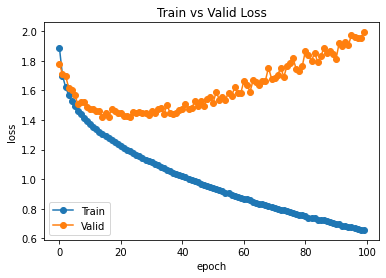

In [ ]:
plt.plot(history.history['loss'], '-o')
plt.plot(history.history['val_loss'], '-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.show()

Para el conjunto de entrenamiento, el valor de la función de coste va descendiendo monótonamente conforme el número de iteraciones va siendo cada vez mayor. La red está aprendiendo a cometer cada vez menos fallos con los datos de entrada que le hemos proporcionado.

Por contra, para el conjunto de prueba se observa cómo inicialmente desciende para volver a subir de nuevo. Así, vemos que se alcanza un mínimo entre la iteración 15 y 30 y a partir de aquí el coste va elevándose de nuevo conforme aumenta el número de iteraciones.

Veamos cómo se comporta la accuracy:


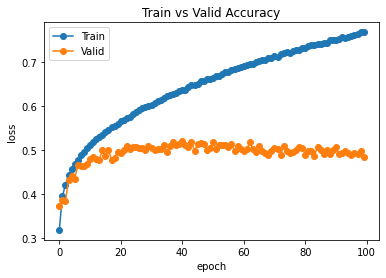

In [ ]:
plt.plot(history.history['accuracy'], '-o', label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], '-o', label='Accuracy (validation data)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

Vemos cómo sobre el conjunto de entrenamiento va mejorando conforme aumentamos el número de iteraciones. Por contra, sobre el conjunto de prueba su valor es sube con el número de iteraciones hasta cierto valor. Entre la iteración 10 y 20 se alcanza una *accuracy* del 50% y se mantiene constante a partir de ese valor.

Estas tendencias nos permiten ver cuándo el modelo presenta *underfitting* o *overfitting*. En efecto, con pocas iteraciones vemos cómo la función de coste baja drásticamente con cada iteración y la *accuracy* sube, tanto en el conjunto de entrenamiento como en el de prueba. Por tanto, un modelo con pocas iteraciones todavía no estaría los suficientemente entrenado como para clasificar correctamente las imágenes. No habría absorbido toda la complejidad que puede aprender del *dataset* de entrenamiento y por lo tanto se dice que presenta *underfitting*. Por otro lado, para un número de iteraciones elevado, vemos cómo la función coste aumenta para el conjunto de prueba y la *accuracy* deja de mejorar. En este caso, nuestro modelo ha dejado de aprender a reconocer las características de nuestro conjunto de entrenamiento y está ajustándose a los ejemplos en sí. Podemos decir que ha pasado a memorizar los datos de entrenamiento. A esta situación se la denomina *overfitting*.

A mayores, podemos calcular los indicadores *precision*, *recall* y *f1-score* así como la matriz de confusión para poder desagregar los errores cometidos por el modelo. Para ello, nos valemos de nuestra familiaridad con la librería *sklearn.metrics*:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_int_encoding = np.argmax(np.array(y_pred), axis=1)

print(f"Informe de Clasificación:\n"
      f"{classification_report(y_test, y_pred_int_encoding, target_names=classes)}")

Informe de Clasificación:
              precision    recall  f1-score   support

       plane       0.43      0.65      0.52      1000
         car       0.55      0.53      0.54      1000
        bird       0.46      0.23      0.30      1000
         cat       0.31      0.20      0.24      1000
        deer       0.56      0.15      0.23      1000
         dog       0.29      0.51      0.37      1000
        frog       0.81      0.16      0.27      1000
       horse       0.43      0.57      0.49      1000
        ship       0.59      0.62      0.61      1000
       truck       0.38      0.68      0.49      1000

    accuracy                           0.43     10000
   macro avg       0.48      0.43      0.41     10000
weighted avg       0.48      0.43      0.41     10000



In [ ]:
confusion_matrix(y_test, y_pred_int_encoding)

array([[652,  39,  22,  11,   6,  26,   3,  24, 118,  99],
       [ 55, 532,   3,  12,   3,  15,   0,  29,  60, 291],
       [174,  28, 227,  58,  28, 250,   6, 119,  31,  79],
       [ 93,  49,  37, 199,  10, 352,  13,  98,  45, 104],
       [132,  18,  88,  53, 147, 204,   9, 227,  43,  79],
       [ 66,  24,  38, 116,  12, 513,   5, 106,  35,  85],
       [ 70,  44,  59, 130,  43, 273, 162,  88,  32,  99],
       [ 85,  22,  16,  27,   7, 111,   0, 570,  17, 145],
       [128,  75,   5,  16,   2,  17,   1,  17, 623, 116],
       [ 56, 135,   3,  18,   3,  24,   2,  34,  49, 676]])

Usando *seaborn* podemos pintar la matriz de confusión usando colores para ver mejor dónde se concentran los aciertos. 

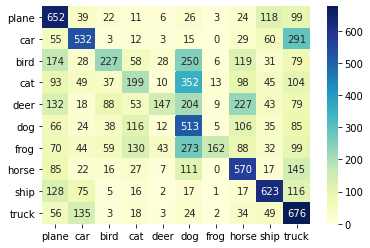

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_int_encoding))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt="d", cmap="YlGnBu", xticklabels=classes, yticklabels=classes)

Cómo vemos, la clase *dog* tiene una *precision* muy baja (29% aprox.). En la matriz de confusión podemos ver como el resto de animales, *cat*, *frog*, *deer*, *bird* y *horse*, son a menudo identificados erróneamente como *dog*.

Por otro lado, la clase *deer* tiene un *recall* muy bajo (15% aprox.). La inmensa mayoría de ciervos son confundidos con otras clases, esencialmente con *dog*.

# Pytorch

A continuación, realizaremos el modelo análogo usando el framework de *Pytorch*. Primero, se importan las librerías y componentes correspondientes:

In [ ]:
import torch
from torch import nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

## Dataset

En este framework, también podemos encontrar el *dataset* de CIFAR-10. La forma de obtenerlo es un poco más compleja que con *Tensorflow*. Aquí, se descargan los conjuntos de entrenamiento y de prueba de forma separada. En el propio método, podemos introducir los parámetros para descargar los datos ya normalizados. Así, con *transform*, indicamos que esperamos obtener la información como un tensor cuyas componentes toman los valores desde -1 a 1.

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# obtenemos el trainset con el parámetro train=True
trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform)
# para aleatorizar el trainset => shuffle=True
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

# obtenemos el testset con el parámetro train=False
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=transform)
# no se necesita agitar el testset => shuffle=False
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Aquí también podemos ver una muestra del *dataset* de entrenamiento:

       ship       truck       truck       horse       truck       plane       truck       horse


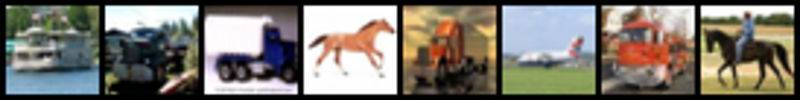

In [ ]:
import torchvision as tv
from torchvision.transforms import ToPILImage
show = ToPILImage()
dataiter = iter(trainloader)   # trainloader is a DataLoader Object 
images, labels = dataiter.next() # Return 4 images and labels images, labels are Tensor images.size () = torch.Size ([4, 3, 32, 32]) lables = tensor ([5, 6, 3, 8])
print(' '.join('%11s'%classes[labels[j]] for j in range(8)))
show(tv.utils.make_grid((images[0:8]+1)/2)).resize((800,100))

Y comprobar de nuevo que nuestros conjuntos de datos están equilibrados:

In [ ]:
np.unique(trainset.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [ ]:
np.unique(testset.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Por lo tanto, la *accuracy* es una métrica fiable del comportamiento global del modelo.

## Modelo

Definimos nuestro modelo de forma muy similar a como lo hicimos con *tensorflow*. Usamos la función Flatten() para convertir el *input* en un vector unidimensional. Definimos la primera capa de entrada con las dimensiones de entrada y de salida, $32 \cdot 32 \cdot 3$ y $128$ respectivamente. Indicamos que la función de activación de las neuronas de la primera capa oculta sea de tipo *relu*. Definimos las sucesivas capas de forma análoga. Al final, indicamos que la activación sobre la última capa se debe realizar con la función *logsoftmax* (que toma la forma $\text{logsoftmax} = -\text{log}(\text{softmax(x)})$), ya que estamos ante un problema de clasificación multiple.

In [ ]:
model_pt = nn.Sequential(nn.Flatten(),
                      nn.Linear(32*32*3, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10), 
                      nn.LogSoftmax(dim=1))

print(model_pt)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
)


Definimos el optimizador, Stochastic Gradient Descent (SGD) y un learning rate de 0.001. También la función de coste a calcular, cross entropy:

In [ ]:
optimizer = optim.SGD(model_pt.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss() # Negative Log Likelihood Loss; NLLL loss + softmax = Cross Entropy


## Entrenamiento

Antes de empezar con el entrenamiento, definimos una función que nos permita volver a reinicializar todos los parámetros de la red de forma aleatoria, destruyendo el conocimiento aprendido. Esto facilita que varias ejecuciones sobre la celda de entrenamiento no den resultados confusos, al evitar que cada vez que se reentrena la red las métricas partan de una posición mejor.

In [ ]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

A continuación, realizamos el entrenamiento de forma explícita en el código, calculando, para cada iteración la *accurcay* y la función coste, tanto para el *dataset* de entrenamiento como para el de prueba:

In [ ]:
from time import time
import datetime

epochs = 100
model_pt.apply(weight_reset)

training_loss_list = []
accuracy_train_list = []
testing_loss_list = []
accuracy_test_list = []

model_pt

for e in range(epochs):
    timeIni = time()
    model_pt.train()
    trn_corr = 0
    test_corr = 0
    running_training_loss = 0
    running_testing_loss = 0
    for batch_train_num, (x_train, y_train) in enumerate(trainloader):
        batch_train_num = batch_train_num + 1
        # inicializa los gradientes de los parámetros
        optimizer.zero_grad()
        # calcula hacia adelante
        logits = model_pt(x_train)  # ejecuta el método forward
        # calcula la pérdida
        loss = criterion(logits, y_train)
        # calcula los gradientes a partir de la pérdida
        loss.backward()
        # actualiza los pesos del modelo aplicando los gradientes a los parámetros
        optimizer.step()

        ######################### 
        ##Metrics
        #########################
        # accuracy
        _, y_pred = torch.max(logits.data, 1)
        total = y_train.size(0)
        batch_corr = (y_pred == y_train).sum() # sumo predicciones correctas en el batch
        trn_corr += batch_corr # acumulo predicciones correctas

        #loss
        running_training_loss += loss.item()

    #promediamos la metrica por iteración    
    accuracy = trn_corr.item()*100 / (batch_train_num*16)
    training_loss = running_training_loss / batch_train_num
    
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S.%f")[:-3]

        # deshabilitamos el cálculo de gradientes; tb vale model_pt.eval()
    with torch.no_grad():
        for batch_test_num, (x_test, y_test) in enumerate(testloader):
            batch_test_num = batch_test_num + 1

            logits = model_pt(x_test)  # ejecuta el método forward
            # escogemos la clase con mayor valor
            _, y_pred = torch.max(logits.data, 1)
            total = y_test.size(0)
            batch_corr = (y_pred == y_test).sum() # sumo predicciones correctas en el batch
            test_corr += batch_corr # acumulo predicciones correctas
            
            loss = criterion(logits, y_test)
            running_testing_loss += loss.item()
        
    accuracy_test = test_corr.item()*100 / (batch_test_num*16)
    testing_loss = running_testing_loss / batch_test_num

    print( f'epoch: {e + 1}/{epochs} - training time: {timeDiff} - training batches: {batch_train_num} - testing batches: {batch_test_num} - training loss: {training_loss} - accuracy train: {accuracy} - testing loss: {testing_loss} - accuracy test: {accuracy_test}')

    training_loss_list.append(training_loss)
    accuracy_train_list.append(accuracy)
    testing_loss_list.append(testing_loss)
    accuracy_test_list.append(accuracy_test)



epoch: 1/100 - training time: 00:22.664 - training batches: 3125 - testing batches: 625 - training loss: 2.183612494812012 - accuracy train: 21.29 - testing loss: 2.067087552642822 - accuracy test: 27.8
epoch: 2/100 - training time: 00:20.257 - training batches: 3125 - testing batches: 625 - training loss: 1.9853383446884156 - accuracy train: 30.564 - testing loss: 1.9071071243286133 - accuracy test: 33.32
epoch: 3/100 - training time: 00:20.338 - training batches: 3125 - testing batches: 625 - training loss: 1.856996668434143 - accuracy train: 34.66 - testing loss: 1.808193316268921 - accuracy test: 36.7
epoch: 4/100 - training time: 00:19.867 - training batches: 3125 - testing batches: 625 - training loss: 1.7768811127853394 - accuracy train: 37.568 - testing loss: 1.741573892402649 - accuracy test: 38.65
epoch: 5/100 - training time: 00:19.414 - training batches: 3125 - testing batches: 625 - training loss: 1.7186400023651123 - accuracy train: 39.604 - testing loss: 1.69106051216125

Las métricas se han ido obteniendo por *batch*. Luego, se ha realizado la media de todos los *batches* pertenecientes a una iteración. De esta forma, se pinta, por cada época, el tiempo de entrenamiento, la cantidad de *batches* usados y las métricas (*accuracy* y *loss*). Así, conseguimos obtener una salida parecida a la que ofrece *tensorflow*.



## Evaluación

Podemos representar gráficamente cómo evoluciona el aprendizaje de la red según aumentan el número de iteraciones realizadas. En concreto, nos fijamos primero en la evolución de la función coste:

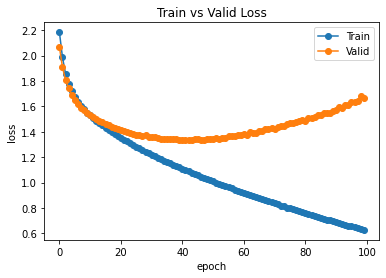

In [ ]:
plt.plot(training_loss_list,'-o')
plt.plot(testing_loss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

El resultado es muy similar al obtenido con *tensorflow*. Para el conjunto de entrenamiento la función coste desciende de forma monótona mientras que para el conjunto de prueba adquiere una forma convexa. En concreto, el mínimo se alcanza alrededor de la iteración 40.


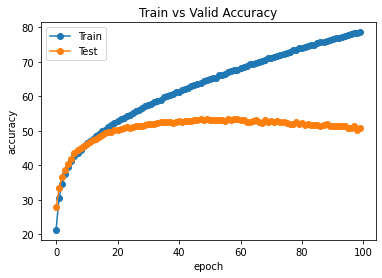

In [ ]:
plt.plot(accuracy_train_list,'-o')
plt.plot(accuracy_test_list,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

Los resultados son muy parecidos a los obtenidos con *tensorflow* y las conclusiones son las mismas. Fundamentalmente, conforme el número de iteraciones se va haciendo mayor, las métricas en el *train* se vuelven significativamente mejores que el *test*, donde vemos un estancamiento e incluso una ligera tendencia a la baja. Estamos llegando a la región de *overfitting*, donde la red se está adaptando muy bien al conjunto de entrenamiento. Seguir entrenando la red, no aumentará nuestra capacidad de predicción.

Veamos ahora qué ocurre para un número de iteraciones bajo:






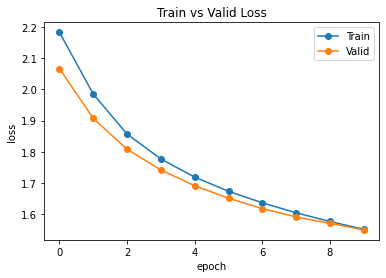

In [ ]:
plt.plot(training_loss_list[0:10],'-o')
plt.plot(testing_loss_list[0:10],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

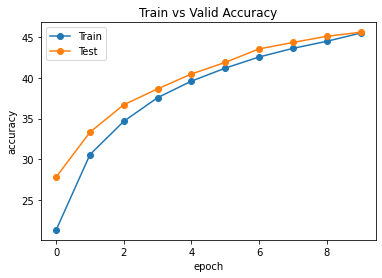

In [ ]:
plt.plot(accuracy_train_list[0:10],'-o')
plt.plot(accuracy_test_list[0:10],'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

Para un número de iteraciones bajo, se observa que sobre el conjunto de prueba se obtienen mejores resultados que sobre el conjunto de entrenamiento. Esto es lógico, pues, para una iteración dada, cuando se aplican las métricas sobre el conjunto de entrenamiento la red todavía se está entrenando y va mejorando con cada *batch*. Por lo que se espera obtener un peor resultado comparado con el el conjunto de prueba, cuyas métricas se aplican con la red ya entrenada en esa iteración.

Al igual que con *tensorflow*, nos valemos de *sklearn* para calcular los principales indicadores en un problema de clasificación, *precision*, *recall* y *f1-score*, así como la matriz de confusión:

In [ ]:
prediction_list = []

with torch.no_grad():
    for batch_test_num, (x_test, y_test) in enumerate(testloader):
        logits = model_pt(x_test)  # ejecuta el método forward
        # escogemos la clase con mayor valor
        _, y_pred = torch.max(logits.data, 1)
        prediction_list.append(y_pred.tolist())

y_pred_pt = [j for i in prediction_list for j in i] # concatenar una lista de listas en una sola lista.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(f"Informe de Clasificación:\n"
      f"{classification_report(testloader.dataset.targets, y_pred_pt, target_names=classes)}")

Informe de Clasificación:
              precision    recall  f1-score   support

       plane       0.59      0.61      0.60      1000
         car       0.62      0.56      0.59      1000
        bird       0.39      0.41      0.40      1000
         cat       0.33      0.31      0.32      1000
        deer       0.43      0.41      0.42      1000
         dog       0.40      0.42      0.41      1000
        frog       0.53      0.58      0.55      1000
       horse       0.62      0.56      0.59      1000
        ship       0.63      0.68      0.65      1000
       truck       0.55      0.55      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



In [ ]:
confusion_matrix(testloader.dataset.targets, y_pred_pt)

array([[611,  41,  64,  21,  36,  14,  27,  22, 114,  50],
       [ 54, 565,  30,  23,   9,  14,  28,  22,  75, 180],
       [ 72,  13, 406,  80, 136,  96, 101,  54,  23,  19],
       [ 30,  25, 100, 311,  68, 233, 122,  40,  26,  45],
       [ 49,  14, 159,  61, 407,  61, 116,  77,  35,  21],
       [ 18,  12,  88, 207,  73, 425,  66,  66,  19,  26],
       [  8,  15,  81, 106,  90,  53, 585,  19,  20,  23],
       [ 35,  14,  58,  62,  82, 103,  26, 557,  12,  51],
       [112,  58,  15,  28,  21,  23,  15,  11, 676,  41],
       [ 52, 155,  28,  43,  14,  32,  24,  35,  70, 547]])

Usando *seaborn* el resultado es más fácil de ver:

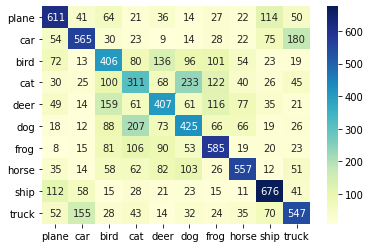

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix(testloader.dataset.targets, y_pred_pt))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt="d", cmap="YlGnBu", xticklabels=classes, yticklabels=classes)

En esta ocasión se obtiene un resultado más uniforme entre las clases. La clase *cat* es la que peor resultados da, con un 33% de *precision* y un 31% de *recall*.

# Conclusiones

Se han entrenado dos modelos de red neuronal en los frameworks de *tensorflow* y *pytorch*. Ambos modelos son de multicapa densa, con las mismas características. Se han obtenido resultados muy parecidos, que se resumen conjuntamente en las siguientes gráficas:

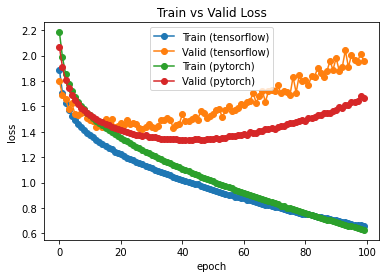

In [ ]:
plt.plot(history.history['loss'], '-o')
plt.plot(history.history['val_loss'], '-o')
plt.plot(training_loss_list,'-o')
plt.plot(testing_loss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train (tensorflow)','Valid (tensorflow)', 'Train (pytorch)','Valid (pytorch)'])
plt.title('Train vs Valid Loss')

plt.show()

Como ya hemos comentado, la función de coste tiene un mínimo para el conjunto de prueba mientras que para el conjunto de entrenamiento desciende monótonamente.

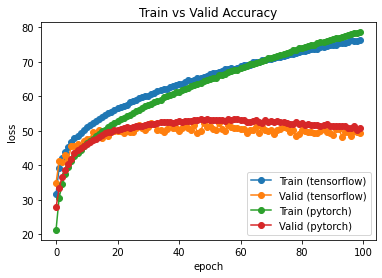

In [ ]:
plt.plot([e * 100 for e in history.history['accuracy']], '-o')# Rescalar la accuracy a porcentaje
plt.plot([e * 100 for e in history.history['val_accuracy']], '-o')
plt.plot(accuracy_train_list,'-o')
plt.plot(accuracy_test_list,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train (tensorflow)','Valid (tensorflow)', 'Train (pytorch)','Valid (pytorch)'])
plt.title('Train vs Valid Accuracy')

plt.show()

En resumen, la *accuracy* de ambos modelos se estanca para el conjunto de prueba a partir de la iteración 20.

Como se puede observar, los resultados difieren levemente de un framework a otro. Con pocas iteraciones estas diferencias podrían ser atribuidas a la inicialización aleatoria de los pesos de la red. Sin embargo, vemos cómo se mantienen conforme aumentan las iteraciones. Las diferencias pueden ser debidas a varias causas: 

* Hemos usado menos datos en *tensorflow* que en *pytorch* para entrenar el modelo. En el primero realizamos una separación del conjunto de entrenamiento para entrenar la red (80%) y para validarla (20%) mientras que para *pytorch* usamos el conjunto en su totalidad. Por tanto, es de esperar que este necesite menos iteraciones para alcanzar la misma exactitud que *tensorflow* al iterar sobre más ejemplos. 

* No se calculan las métricas de la misma forma en un framework y en otro. En efecto, en *tensorflow* los resultados se van actualizando dentro de la misma iteración, tomando como resultado de la iteración un subconjunto final de batches. En *pytorch* calculamos las métricas para cada batch y se hace la media para obtener el resultado por iteración. 

* Tampoco hemos empleado la misma normalización. Esto afecta fundamentalmente al *learning_rate*, el cual no es invariante ante un cambio como este. Así, la velocidad de aprendizaje de la red podría verse afectada. 

Además de la *accuracy*, también se han analizado los indicadores *precision*, *recall* y *f1-score* así como la matriz de confusión. Se ha visto que el modelo de *tensorflow* tiende a clasificar cualquier animal del conjunto como un perro (*dog*) y que la inmensa mayoría de ciervos (*deer*) son erróneamente identificados en otras clases (sobre todo se etiquetan como perros). Por su lado, en *pytorch* la clase *cat* tienen unos indicadores de *precision* y *recall* bajos.  

Como conclusión final, observamos que la *accuracy* y el indicador *f1-score* son muy pobres. Por lo que este tipo de arquitectura no es especialmente buena a la hora de clasificar imágenes. Uno de los motivos principales reside en que los modelos no poseen una noción de localidad entre los píxeles de las imágenes (Recordemos que estamos introduciendo cada fotografía como una sucesión unidimensional de valores). Este problema quedará resuelto con las redes convolucionales, en las que sí se pueden extraer este tipo de características.